# Load in Data

In [1]:

import csv
import numpy as np 
import numpy as np
import re
import pandas as pd 
#max rows pandas 
pd.set_option('display.max_rows', 10_000)
pd.set_option('display.max_columns', None)


# Function to read CSV file and extract columns
def read_csv(file_path):
    columns = {}
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for column in reader.fieldnames:
            columns[column] = []
        for row in reader:
            for column in reader.fieldnames:
                columns[column].append(row[column])
    return columns

def split_response(input):
    input = "\\n\\n1)" + input[34:-57]

    result = re.split(r'\\n\\n\d\)', input)
    for i in range(len(result)):
        result[i] = re.split(r'(\\n\d\.\d\d?|\\n\d\.\d)', result[i])

    for i in range(len(result)):
        indicesToRemove = []
        for j in range(len(result[i])):
            if len(result[i][j]) < 8:
                indicesToRemove.append(j)
        indicesToRemove.reverse()
        for j in indicesToRemove:
            result[i].remove(result[i][j])
    return result[1:]

In [4]:
gpt_separate = read_csv("./Separate_Pairs_FINAL_Result_wGPT.csv")["GPT"]
cagpt_separate = read_csv("./Separate_Pairs_FINAL_Result_wGPT.csv")["CAGPT"]
#gpt_mixed = read_csv("./Mixed_Pairs_FINAL_Result_wGPT.csv")["GPT"]
#cagpt_mixed= read_csv("./Mixed_Pairs_FINAL_Result_wGPT.csv")["CAGPT"]



gpt = gpt_separate #+ gpt_mixed
cagpt = cagpt_separate #+ cagpt_mixed



# Initialize lists to store BERT embeddings
gpt_embeddings = [[],[],[],[],[]]
cagpt_embeddings = [[],[],[],[],[]]

for i in range(len(gpt)):
    gpt[i] = split_response(gpt[i])

for i in range(len(cagpt)):
    cagpt[i] = split_response(cagpt[i])

while i < len(gpt):
    if len(gpt[i]) != 5:
        gpt.remove(gpt[i])
        i = i-1
    i+=1

for i in range(len(cagpt)):
    if len(cagpt[i]) != 5:
        cagpt.remove(cagpt[i])
        i = i-1
    if i+1 == len(cagpt):
        break





In [5]:
gpt # privacy statement, question, responses

questions = []

for k,privacy in enumerate(gpt):
    for j,question in enumerate(privacy):
        for response in question:
            questions.append(
                {"privacy statement number ": k, "question": j, "response": response,"type": "GPT"}
            )

cagpt # privacy statement, question, responses
caquestions = []   

for k,privacy in enumerate(cagpt):
    for j,question in enumerate(privacy):
        for response in question:
            caquestions.append(
                {"privacy statement number ": k, "question": j, "response": response,"type": "CAGPT"}
            )



# Get Embeddings

In [4]:
import dotenv 
dotenv.load_dotenv()

True

In [5]:
from openai import OpenAI
client = OpenAI()
model ='text-embedding-3-large'
def get_embedding(texts, model=model ):
   #text = text.replace("\n", " ")
   return client.embeddings.create(input = texts, model=model).data



In [14]:
embeddings = [ ]
for j in range(0,len(questions),100):
    texts = [x['response'] for x in questions[j:j+100]]
    response = get_embedding(texts)
    embeddings.extend([x.embedding for x in response])


In [34]:
embeddings_ca = [ ]
for j in range(0,len(caquestions),100):
    texts = [x['response'] for x in caquestions[j:j+100]]
    response = get_embedding(texts)
    embeddings_ca.extend([x.embedding for x in response])

In [17]:

embeddings_arr = np.vstack(embeddings)

In [36]:
embeddings_ca_arr = np.vstack(embeddings_ca)

In [37]:
np.save("embeddings/gptca", embeddings_ca_arr)

In [39]:
embeddings_ca_arr.shape 

(6554, 3072)

In [23]:
#save 
np.save("./embeddings/gpt", embeddings_arr)


In [24]:
embeddings_arr.shape 

(5535, 3072)

# Work with Embeddings

In [6]:
def cosine_simalarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

In [7]:
embeddings_arr = np.load("embeddings/gpt.npy")

In [8]:
embeddings_ca_arr = np.load("embeddings/gptca.npy")

In [9]:
threshold = .6
x = embeddings_arr[0,:] # corresponds to information directly collected from user

###


sims = []
for j in range(0,len(questions)):
    cs = cosine_simalarity(x,embeddings_arr[j,:])
    sims.append(cs)
    if cs > threshold:
        print(questions[j]['response'])
print("------------------------------------")
for j in range(0,len(caquestions)):
    cs = cosine_simalarity(x,embeddings_ca_arr[j,:])
    sims.append(cs)
    if cs > threshold:
        print(caquestions[j]['response'])

 Information is collected directly from users when they interact with the website, such as through purchases, account creation, or communication.
 Information provided directly by users is collected through online services like websites or mobile applications. 
 Information provided directly by users through offline interactions is collected, such as when submitting rebate claims by mail or calling customer service.
 Personal information provided directly by users. 
 Personal Information is collected when registering for an account, making a purchase, using web forms, engaging on social media, updating account information, chatting with customer support, or corresponding with the company.
 Information is collected through online forms, information entered or provided when purchasing products or services, completing job applications, entering sweepstakes.
 User provides personal information directly to Publisher through website interactions, email subscriptions, or form submissions.
 Pe

<Axes: ylabel='Count'>

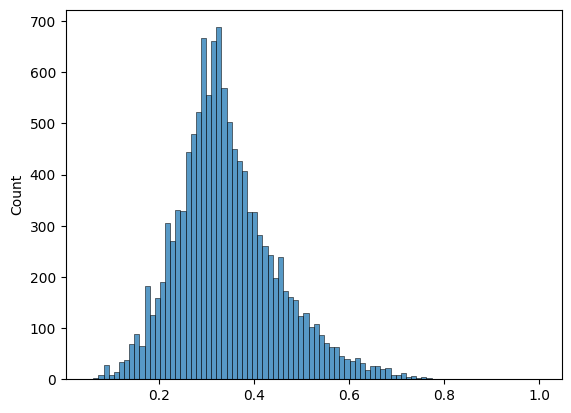

In [10]:
import seaborn as sns 
sns.histplot(sims)

Seeing the distribution allows us to figure what a good threshold for the cosine simiilarity should be. Here we see around .5-.8.

In [11]:
for j in range(len(questions)):
    questions[j]['embedding'] = embeddings_arr[j,:]
for j in range(len(caquestions)):
    caquestions[j]['embedding'] = embeddings_ca_arr[j,:]


In [12]:
len(questions) + len(caquestions)

12089

In [14]:
#put into pandas dataframe
import pandas as pd
df = pd.DataFrame(questions)
#df = df.append(pd.DataFrame(caquestions))
df = pd.concat([df, pd.DataFrame(caquestions)], ignore_index=True)
df.head() 

,privacy statement number,question,response,type,embedding
0,0,0,Information is collected directly from users ...,GPT,"[-0.033987488597631454, 0.01902325265109539, -..."
1,0,0,Log and device information are collected auto...,GPT,"[-0.0072717852890491486, 0.004054248332977295,..."
2,0,0,Information is obtained from third-party sour...,GPT,"[-0.008600250817835331, -0.022183965891599655,..."
3,0,1,"Name, email address, zip or postal code, bill...",GPT,"[-0.015137944370508194, 0.023861505091190338, ..."
4,0,1,"Log information including browser type, acces...",GPT,"[-0.002065186155959964, -0.011139274574816227,..."


In [36]:
question_number = 0 #embeddings for question 1 

q1 = df[df['question'] == question_number].reset_index(drop=True)
X = np.vstack(q1['embedding'])
X.shape 

(2498, 3072)

In [37]:
epsilon = 0.15 # epsilon can be adjusted.
#smaller epsilon means more clusters

from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=epsilon ,  metric='cosine') 
clustering.fit(X)

DBSCAN(eps=0.15, metric='cosine')

In [38]:
#count number of each lable 
from collections import Counter
Counter(clustering.labels_)

Counter({-1: 2283,
         7: 26,
         12: 22,
         0: 14,
         8: 14,
         1: 12,
         2: 12,
         19: 11,
         6: 10,
         9: 10,
         11: 10,
         16: 9,
         4: 7,
         3: 6,
         13: 6,
         18: 6,
         5: 5,
         21: 5,
         10: 5,
         14: 5,
         15: 5,
         17: 5,
         20: 5,
         22: 5})

In [39]:
with open(f"clusters/Question{question_number + 1}.txt", "w",encoding="utf-8") as f:
    for cluster_number in range(0,np.max(clustering.labels_)+1):
        q1['cluster'] = clustering.labels_
        mask = q1['cluster'] == cluster_number
        tmp = q1[mask][['type','response']].to_dict(orient='records')
        f.write(f"Cluster {cluster_number}\n")
    
        for x in tmp:
            f.write(x['type']+": "+x['response'])
            f.write("\n")
        f.write("---------------------------\n")
    # same thing for cluster_number == -1
    mask = q1['cluster'] == -1
    tmp = q1[mask][['type','response']].to_dict(orient='records')
    f.write(f"Unclassified Clusters \n")
    for x in tmp:
        f.write(x['type']+": "+x['response'])
        f.write("\n")

# Extra

In [20]:
cluster_number = 10  #pick cluster number 10 from above cell 

q1['cluster'] = clustering.labels_
mask = q1['cluster'] == cluster_number
tmp = q1[mask][['type','response']].to_dict(orient='records')
for x in tmp:
    print(x['type'],": ",x['response'])
    print("---------------")

GPT :   Transaction Data provided to third parties
---------------
GPT :   Transaction Data provided to third parties
---------------
GPT :   Payment Information provided to third parties
---------------
GPT :   Transaction Data provided to third parties
---------------
GPT :   Transaction Information provided to third parties
---------------
GPT :   Payment Data provided to third parties
---------------
CAGPT :   Transaction Information provided to third parties 
---------------
